# Exploratory Data Analysis: Data Story on the History of Philosophy
#### **author: Tomasz Wislicki**
##### UNI: TW2638
##### version: 1.8 December 29, 2022


In [16]:
# Importing Packages 
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import nltk
from wordcloud import WordCloud
import wordcloud
import utils
from nltk.sentiment import SentimentIntensityAnalyzer
from nrclex import NRCLex
from collections import Counter
from math import pi

-----------------------------------------------------------
-----------------------------------------------------------
### 1. Loading and preprocessing data

In [24]:
# Loading Data
df_raw=pd.read_csv("/Users/tomcio/Desktop/Project 1/data/philosophy_data.csv")

In [25]:
# Examine data
df_raw.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360808 entries, 0 to 360807
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   title                      360808 non-null  object
 1   author                     360808 non-null  object
 2   school                     360808 non-null  object
 3   sentence_spacy             360808 non-null  object
 4   sentence_str               360808 non-null  object
 5   original_publication_date  360808 non-null  int64 
 6   corpus_edition_date        360808 non-null  int64 
 7   sentence_length            360808 non-null  int64 
 8   sentence_lowered           360808 non-null  object
 9   tokenized_txt              360808 non-null  object
 10  lemmatized_str             360808 non-null  object
dtypes: int64(3), object(8)
memory usage: 30.3+ MB


Exploratory analysis using .info() pandas function shows that the full dataset has non-null 360808 values in each column, thus confirming that the dataset is complete 

In [26]:
# Add Sentiment Analysis columns
sia = SentimentIntensityAnalyzer()

# create a new column in the DataFrame to store the sentiment scores
df_raw['sentiment_scores'] = df_raw['sentence_str'].apply(lambda x: sia.polarity_scores(x))

# extract the values from the sentiment_scores dictionary and assign them to new columns
# compound score ranges from -1 (neg) through 0 (neu) to 1 (pos)
df_raw['neg'] = df_raw['sentiment_scores'].apply(lambda x: x['neg'])
df_raw['neu'] = df_raw['sentiment_scores'].apply(lambda x: x['neu'])
df_raw['pos'] = df_raw['sentiment_scores'].apply(lambda x: x['pos'])
df_raw['compound_sent_score'] = df_raw['sentiment_scores'].apply(lambda x: x['compound'])

# Drop columns we are not going to use (all sentiment columns except of compund)
df_raw.drop(columns=['sentence_spacy','corpus_edition_date','sentiment_scores','pos','neg','neu'], inplace=True)

# Rename 'original_publication_date' column to 'year' for operational ease
df_raw.rename(columns = {'original_publication_date':'year'}, inplace = True)
df_raw.head(10)

,title,author,school,sentence_str,year,sentence_length,sentence_lowered,tokenized_txt,lemmatized_str,compound_sent_score
0,Plato - Complete Works,Plato,plato,"What's new, Socrates, to make you leave your ...",-350,125,"what's new, socrates, to make you leave your ...","['what', 'new', 'socrates', 'to', 'make', 'you...","what be new , Socrates , to make -PRON- lea...",-0.2960
1,Plato - Complete Works,Plato,plato,Surely you are not prosecuting anyone before t...,-350,69,surely you are not prosecuting anyone before t...,"['surely', 'you', 'are', 'not', 'prosecuting',...",surely -PRON- be not prosecute anyone before ...,0.4404
2,Plato - Complete Works,Plato,plato,The Athenians do not call this a prosecution b...,-350,74,the athenians do not call this a prosecution b...,"['the', 'athenians', 'do', 'not', 'call', 'thi...",the Athenians do not call this a prosecution ...,-0.3346
3,Plato - Complete Works,Plato,plato,What is this you say?,-350,21,what is this you say?,"['what', 'is', 'this', 'you', 'say']",what be this -PRON- say ?,0.0000
4,Plato - Complete Works,Plato,plato,"Someone must have indicted you, for you are no...",-350,101,"someone must have indicted you, for you are no...","['someone', 'must', 'have', 'indicted', 'you',...","someone must have indict -PRON- , for -PRON- ...",0.0000
5,Plato - Complete Works,Plato,plato,But someone else has indicted you?,-350,34,but someone else has indicted you?,"['but', 'someone', 'else', 'has', 'indicted', ...",but someone else have indict -PRON- ?,0.0000
6,Plato - Complete Works,Plato,plato,"I do not really know him myself, Euthyphro.",-350,43,"i do not really know him myself, euthyphro.","['do', 'not', 'really', 'know', 'him', 'myself...","-PRON- do not really know -PRON- -PRON- , Eut...",0.0000
7,Plato - Complete Works,Plato,plato,He is apparently young and unknown.,-350,35,he is apparently young and unknown.,"['he', 'is', 'apparently', 'young', 'and', 'un...",-PRON- be apparently young and unknown .,0.0000
8,Plato - Complete Works,Plato,plato,"They call him Meletus, I believe.",-350,33,"they call him meletus, i believe.","['they', 'call', 'him', 'meletus', 'believe']","-PRON- call -PRON- Meletus , -PRON- believe .",0.0000
9,Plato - Complete Works,Plato,plato,"He belongs to the Pitthean deme, if you know a...",-350,147,"he belongs to the pitthean deme, if you know a...","['he', 'belongs', 'to', 'the', 'pitthean', 'de...","-PRON- belong to the Pitthean deme , if -PRON...",0.0000


 In the code above, I'm performing sentiment analysis on the string sentences of the df_raw entries in 'sentence_str' using the SentimentIntensityAnalyzer from the nltk package. I'm creating new columns corresponding to sentiment scores from the sia.polarity_scores output including: negativity, neutrality, positivity, and a compound score that ranges from from -1 (neg) through 0 (neu) to 1 (pos). Since compound sentiment variable is a metric that quantifies the overall sentiment balancing output of all of the above columns, for convenience I'm dropping all other sentiment columns as well as the 'sentence_spacy','corpus_edition_date','sentiment_scores' which we will not be using aymore.

-----------------------------------------------------------
-----------------------------------------------------------
### 2. Exploratory Data Analysis (EDA): Full Dataset

#### 2.1 Dataframe Frequency Grouping
The code below creates a dataframe grouped_df by concatenating two dataframes: first which is grouping the rows in df_raw by the school, author, and title columns and then taking the mean of the sentence_length compound_sent_score columns with second dataframe, which is obtained by grouping the rows in df_raw by the school, author, and title columns and taking a count of the title column.

The output grouped_df allows to explore the full dataset across different authors and works within each school, the year of the work, mean sentence length, mean compund sentiment score and number of sentences composing the work.

In [27]:
# Create a dataframe with mean values of sentence length and compound sentiment scores grouped across titles, authors and schools of thought
grouped_df = pd.concat([df_raw.groupby(by=['school','author','title']).mean().round(2), pd.DataFrame(df_raw.groupby(by=['school','author','title'])['title'].count())], axis=1)

# Formatting
grouped_df.rename(columns={'sentence_length': 'mean_sentence_length', 'compound_sent_score': 'mean_compound', 'title': 'freq_of_sentences'}, inplace=True) # rename the mean and freq columns
grouped_df['year'] = grouped_df['year'].apply(lambda x: round(x, -1)) #round the 'year' column entries to the nearest integer
grouped_df['year'] = grouped_df['year'].astype(int) #convert the rounded values in the 'year' column to integers

grouped_df

year  \
school          author          title                                                      
analytic        Kripke          Naming And Necessity                                1970   
                                Philosophical Troubles                              1980   
                Lewis           Lewis - Papers                                      1980   
                Moore           Philosophical Studies                               1910   
                Popper          The Logic Of Scientific Discovery                   1960   
                Quine           Quintessence                                        1950   
                Russell         The Analysis Of Mind                                1920   
                                The Problems Of Philosophy                          1910   
                Wittgenstein    On Certainty                                        1950   
                                Philosophical Investigations                        1950   
                                Tractatus Logico-Philosophicus                      1920   
aristotle       Aristotle       Aristotle - Complete Works                          -320   
capitalism      Keynes          A General Theory Of Employment, Interest, And M...  1940   
                Ricardo         On The Principles Of Political Economy And Taxa...  1820   
                Smith           The Wealth Of Nations                               1780   
communism       Lenin           Essential Works Of Lenin                            1860   
                Marx            Capital                                             1880   
                                The Communist Manifesto                             1850   
continental     Deleuze         Anti-Oedipus                                        1970   
                                Difference And Repetition                           1970   
                Derrida         Writing And Difference                              1970   
                Foucault        History Of Madness                                  1960   
                                The Birth Of The Clinic                             1960   
                                The Order Of Things                                 1970   
empiricism      Berkeley        A Treatise Concerning The Principles Of Human K...  1710   
                                Three Dialogues                                     1710   
                Hume            A Treatise Of Human Nature                          1740   
                                Dialogues Concerning Natural Religion               1780   
                Locke           Essay Concerning Human Understanding                1690   
                                Second Treatise On Government                       1690   
feminism        Beauvoir        The Second Sex                                      1950   
                Davis           Women, Race, And Class                              1980   
                Wollstonecraft  Vindication Of The Rights Of Woman                  1790   
german_idealism Fichte          The System Of Ethics                                1800   
                Hegel           Elements Of The Philosophy Of Right                 1820   
                                Science Of Logic                                    1820   
                                The Phenomenology Of Spirit                         1810   
                Kant            Critique Of Judgement                               1790   
                                Critique Of Practical Reason                        1790   
                                Critique Of Pure Reason                             1780   
nietzsche       Nietzsche       Beyond Good And Evil                                1890   
                                Ecce Homo                                           1890   
                                The 

-----------------------------------------------------------
#### 2.2 Frequency and Distibution of Sentence Entries in the Dataset Across Authors and Schools of Thought
##### 2.2.1 Frequency of Entries Across Authors and Schools of Thought
Using the seaborn library, the code generates two bar plots visualising the distribution of sentences in the dataset by author and school columns, which are sorted in decreasing order.


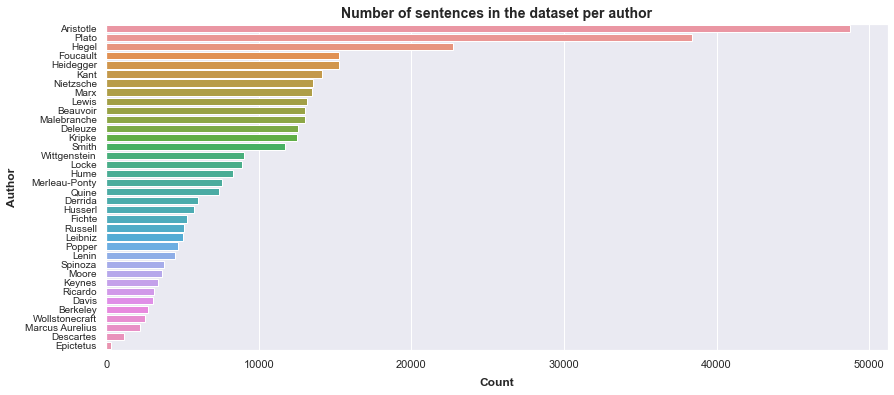

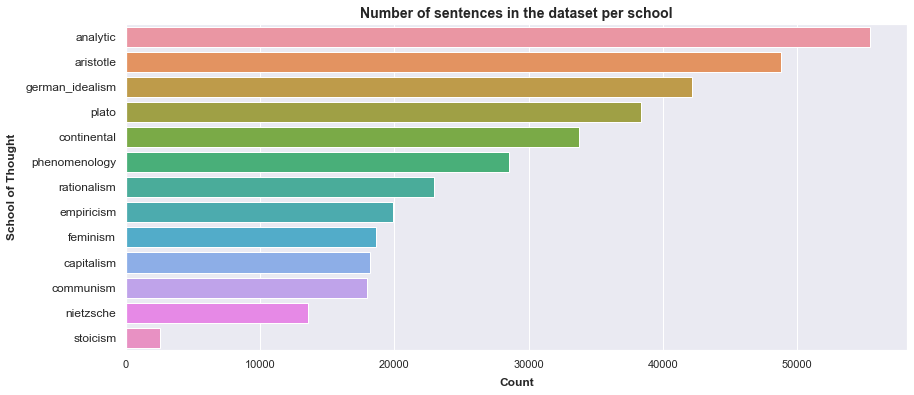

In [28]:
# create the first figure and subplot
fig1, ax1 = plt.subplots(1, 1)

# set the size and background color of the figure
fig1.set_size_inches(14, 6)
fig1.set_facecolor('white')

# create the first bar plot
sns.countplot(y='author', data=df_raw, order = df_raw['author'].value_counts().index, ax=ax1)
ax1.grid(True, axis='x')
ax1.set_yticklabels(ax1.get_yticklabels(), size = 10)
ax1.set_title('Number of sentences in the dataset per author', fontsize=14, fontweight='bold')
ax1.set_ylabel('Author', fontsize=12, labelpad=8, fontweight='bold')
ax1.set_xlabel('Count', fontsize=12, labelpad=8, fontweight='bold')

plt.show()

# create the second figure and subplot
fig2, ax2 = plt.subplots(1, 1)

# set the size and background color of the figure
fig2.set_size_inches(14, 6)
fig2.set_facecolor('white')

# create the second bar plot
sns.countplot(y='school', data=df_raw, order = df_raw['school'].value_counts().index, ax=ax2)
ax2.set_yticklabels(ax2.get_yticklabels(), size = 12)
ax2.set_title('Number of sentences in the dataset per school', fontsize=14, fontweight='bold')
ax2.set_ylabel('School of Thought', fontsize=12, labelpad=8, fontweight='bold')
ax2.set_xlabel('Count', fontsize=12, labelpad=8, fontweight='bold')

plt.show()

##### 2.2.1 Distribution of Entries Across Authors and Schools of Thought
Similarly to the two plots above, the code below shows the composition of dataset in terms of frequency of entries across authors and schools of thought 

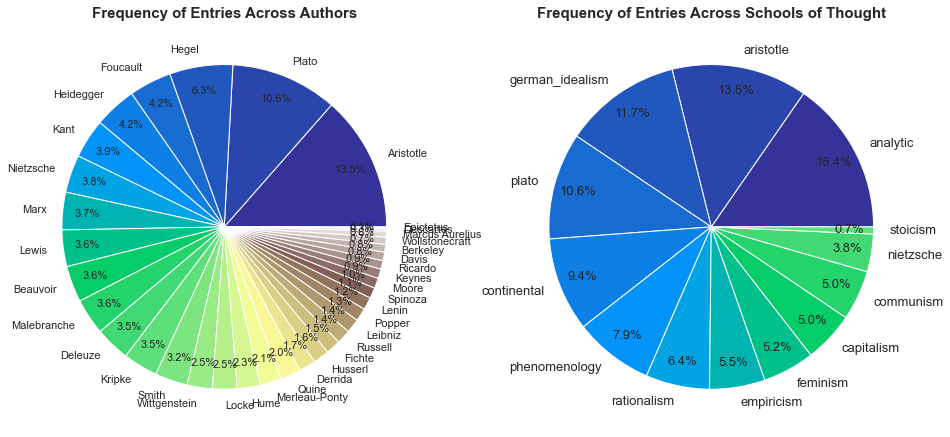

In [29]:
# count the number of entries for each author
author_counts = df_raw['author'].value_counts()
school_counts = df_raw['school'].value_counts()

# extract the labels (author names) and values (counts) from the Series
labels_author = author_counts.index
values_author = author_counts.values
labels_school = school_counts.index
values_school = school_counts.values

# create the subplots
fig, (ax1, ax2) = plt.subplots(1, 2)

# set the size and background color of the subplots
fig.set_size_inches(16, 10)
fig.set_facecolor('white')

# define the labels variable
labels = ['Label {}'.format(i) for i in range(len(values_author))]

# create a rainbow gradient colormap
colormap = cm.terrain(np.linspace(0, 1, len(labels)))

# create the first pie chart with the percentage labels closer to the edge
ax1.pie(values_author, labels=labels_author, autopct='%1.1f%%', pctdistance=0.85, colors=colormap, textprops={'fontsize': 11})
ax1.set_title('Frequency of Entries Across Authors', fontsize=15, fontweight='bold')


# create the second pie chart with the percentage labels closer to the edge
ax2.pie(values_school, labels=labels_school, autopct='%1.1f%%', pctdistance=0.85, colors=colormap, textprops={'fontsize': 13})
ax2.set_title('Frequency of Entries Across Schools of Thought', fontsize=15, fontweight='bold')


plt.show()

The four figures above show that the dataset has significant data frequency discrepancies across philosophers and schools of thought, with an enormously larger presence of analytic, aincient and idealist sentences from authors like Plato, Aristotle, Hegel, Feoucault, Heidegger and Kant. The divergence between the most populated authors and least populated authors is more than 1000-fold, similarly with respect to schools of thought.

-----------------------------------------------------------
#### 2.3 Publications Across Time Grouped by Authors and Schools of Thought

Using the plot() function from the matplotlib package, the code below creates two line plots showing, first the distribution of philosophers across time, and, second, the distribution of schools of thought across time.


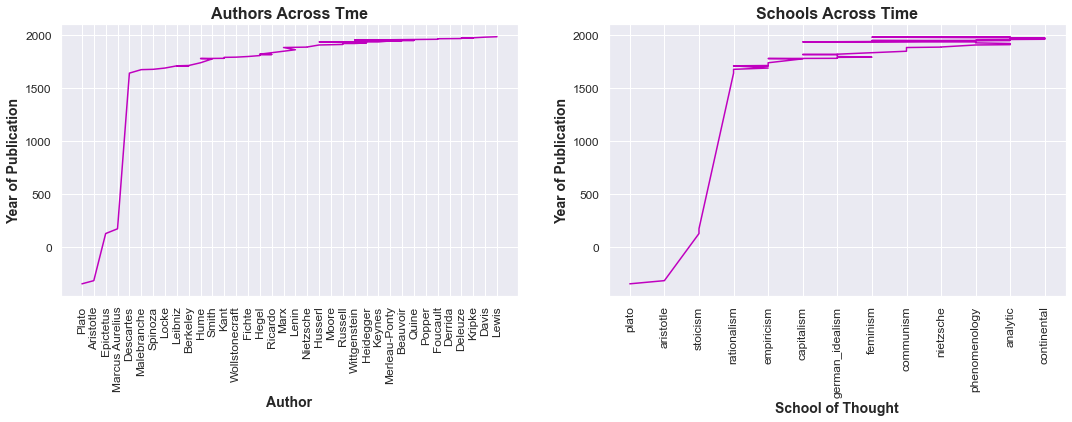

In [493]:
# Line plot representing the distribution of philosophers across time
time_dat_raw = df_raw[['author', 'year']].sort_values(by=['year'], ascending=True)

# Create a figure with size (16, 10) inches
fig = plt.figure(figsize=(18, 5))

# Create a subplot with 1 row and 2 columns, and set the current subplot to be the first subplot
plt.subplot(1, 2, 1)

# Plot the first line plot
plt.plot(time_dat_raw['author'], time_dat_raw['year'], color='#bf00bf')
plt.xticks(rotation=90)
plt.tick_params(labelsize=12)  # Decrease the font size of the tick labels
plt.xlabel('Author', fontsize=14, fontweight='bold')
plt.ylabel('Year of Publication', fontsize=14, fontweight='bold')
plt.title("Authors Across Tme", fontsize=16, fontweight='bold')

# Set the current subplot to be the second subplot
plt.subplot(1, 2, 2)

# Line plot representing the distribution of philosophers across time
time_dat_raw = df_raw[['school', 'year']].sort_values(by=['year'], ascending=True)

# Plot the second line plot
plt.plot(time_dat_raw['school'], time_dat_raw['year'], color='#bf00bf')
plt.xticks(rotation=90)
plt.tick_params(labelsize=12)  # Decrease the font size of the tick labels
plt.xlabel('School of Thought', fontsize=14, fontweight='bold')
plt.ylabel('Year of Publication', fontsize=14, fontweight='bold')
plt.title("Schools Across Time", fontsize=16, fontweight='bold')

# Show the plots
plt.show()

Both graphs display a significant jump from aincient philosophers and schools of thought like Plato, Aristotle and the Stoics (Epictetus and Marcus Aurelius), illustrating the historiographical gap in philosophical work between the fall of rome in the 400s and the rise of rationalist philosophers like descartes in the 1600s, which is otherwise known as the 'dark ages' of Christian repression of western philosophical thought. 

-----------------------------------------------------------
#### 2.4 Sentence Length Across Authors and Schools of Thought
The code below creates two bar plots showing the distribution of mean sentence length across authors and the distribution of mean sentence length across schools of thought.

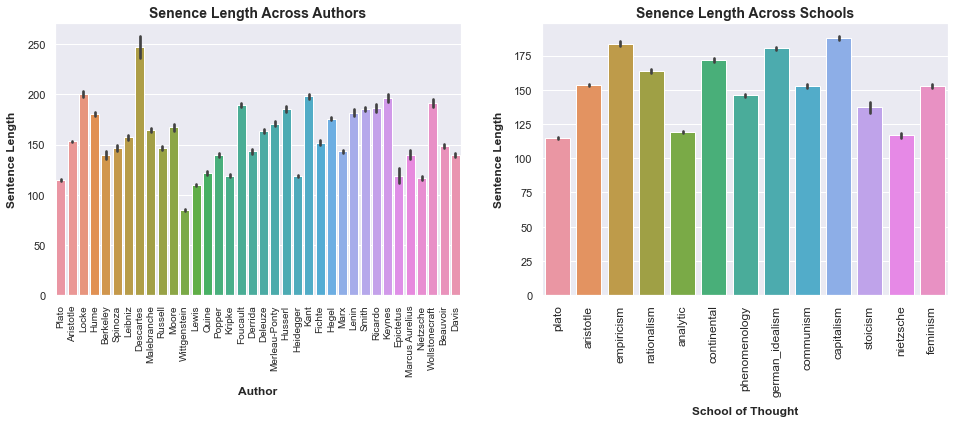

In [494]:
# create the subplots
fig, (ax1, ax2) = plt.subplots(1, 2)

# set the size and background color of the subplots
fig.set_size_inches(16, 5)
fig.set_facecolor('white')

# create the first bar plot
sns.barplot(x='author', y='sentence_length', data=df_raw, ax=ax1)
ax1.grid(True, axis='y')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, size = 10)
ax1.set_ylabel("Sentence Length", fontsize=12, labelpad=10, fontweight='bold')
ax1.set_xlabel('Author', fontsize=12, labelpad=10, fontweight='bold')
ax1.set_title("Senence Length Across Authors", fontsize=14, fontweight='bold')



# create the second bar plot
sns.barplot(x='school', y='sentence_length', data=df_raw, ax=ax2)
ax2.grid(True, axis='y')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, size = 12)
ax2.set_ylabel('Sentence Length', fontsize=12, labelpad=10, fontweight='bold')
ax2.set_xlabel('School of Thought', fontsize=12, labelpad=10, fontweight='bold')
ax2.set_title("Senence Length Across Schools", fontsize=14, fontweight='bold')


plt.show()



From a very general, high-level perspective, the two figures suggest lack of any strong patterns between the more analytical authors belonging to schools of thought like analytic or empiricist philosophy, and authors belonging to more emotional, flowery schools of thought like continental philosophy and phenomenology. I expected the analytical texts to be shorter, while the more high-level philosophy like ideology to be more flowery, and descriptive, which should show noticeable differences in mean sentence length. Nevertheless, this analyis is far to high-level to completely reject any potential patterns--to explore for such relationships further analysis should group the schools and authors according to expected thesis, and analyise the string contents by parts of speech and such.

-----------------------------------------------------------
#### 2.4 Sentence Length and Sentiment Distibution Across Schools of Thought
Having realised that EDA across authors is far too granular of a scope for exploration at such high-level stage, I decided to analyse sentiment and sentence length in terms of frequency distributions across schools.

Using the seaborn library's boxenplot function, the code below generates two violin plots showing the distribution of sentence lengths for each school and the distribution of compound sentiment scores for each school.

Text(0, 0.5, 'Compound Sentiment Value')

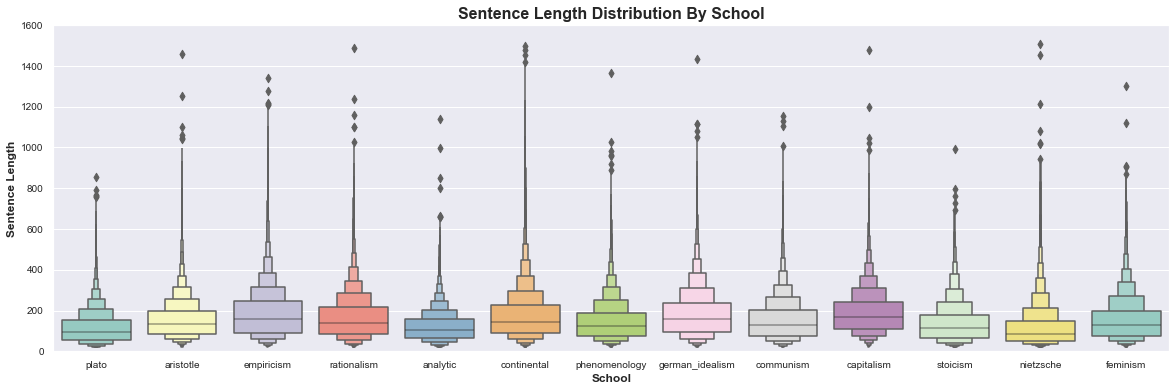

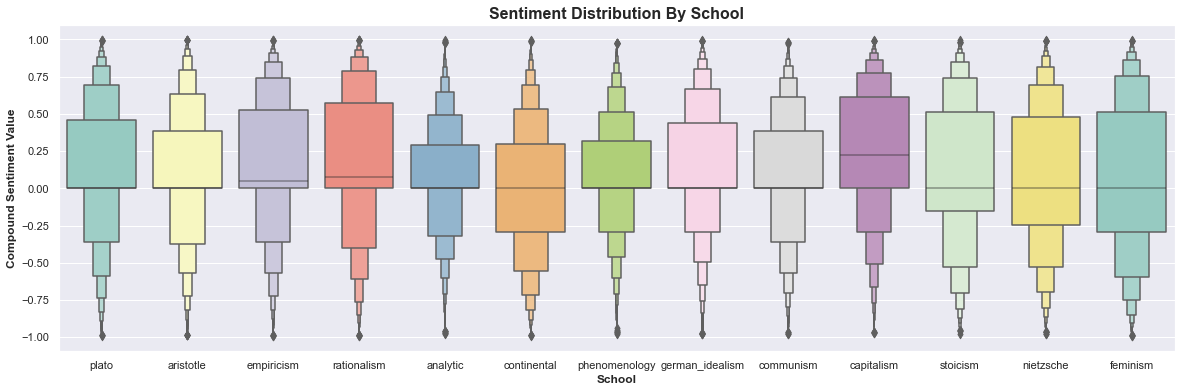

In [495]:

# plot sentence length split by school
plt.figure(figsize=(20,6))
sns.set(font_scale=1.5)
sns.boxenplot(x='school', y='sentence_length', data=df_raw, palette="Set3")
plt.title('Sentence Length Distribution By School', fontsize=16, fontweight='bold')
plt.xlabel('School', fontsize=12, fontweight='bold')
plt.ylabel('Sentence Length', fontsize=12, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=10) # Decrease tick size
plt.ylim(0,1600) # Limit y-axis range

# plot compound sentiment split by school
plt.figure(figsize=(20,6))
sns.set(font_scale=1)
sns.boxenplot(x='school', y='compound_sent_score', data=df_raw, palette="Set3")
plt.title('Sentiment Distribution By School', fontsize=16, fontweight='bold')
plt.xlabel('School', fontsize=12, fontweight='bold')
plt.ylabel('Compound Sentiment Value', fontsize=12, fontweight='bold')



The sentence length frequency distribution plot suggest a general consistency in mean length, but significant differences in distributions of the aspect, suggesting that sentence length distributions across schools could definietly prove for a very content-rich focus in potential future analysis. Similarly, the distribution of compound sentiment scores of sentences across schools of thought shows that distribution differences are very noticeable, with a general tred of most means to oscilate around the 0, which designates nautrality, proving that philosophy can generally be seen as an objective type of writing. Interestingly, most schools consistently stray towards positive sentiment scores, which makes sense with respect to constructive philosophy, where philosophical concepts are created from scratch, but goes against my expectations of critical theories, which I thought would be more negatively traited, since argument building processes there are mostly derived from critique.

-----------------------------------------------------------
#### 2.3 Compound Sentiment Score Across Time

Sentiment could also be very interesting to analyse across time. 
This code generates a line plot of the compound sentiment score as a function of the year column. The plot is created using the lineplot function from the seaborn package with the purpose of visualizing the relationship between the sentiment score and year in the data.

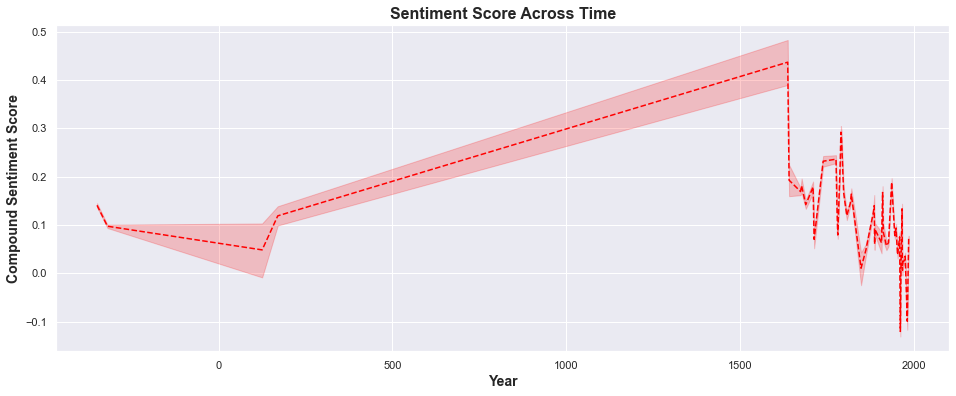

In [496]:
plt.figure(figsize=(16,6))
sns.lineplot(data=df_raw, x='year', y='compound_sent_score', linestyle='--', color='red')
plt.grid(True)
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Compound Sentiment Score', fontsize=14, fontweight='bold')
plt.title("Sentiment Score Across Time", fontsize=16, fontweight='bold')
plt.show()

In spite of the huge gaps of data between aincient times and modern philosophy discussed above skewing the plot, the figure displays a noticeable downfall of sentiment scores around 1600s, converging towards neutrality, and closer to modernity even falling to negative sentiments, which is consistent with my thesis above, suggesting that the emergence of critical theory-based philosophy in the modern times made written work more negatively charged. 

-----------------------------------------------------------
-----------------------------------------------------------
### 3. Exploratory Data Analysis (EDA): Analytic vs Continental Schools of Thought
Given the many tools above, I decided to narrow the scope of my exploratory analysis to investigate a long-standing debate between one two of the most influential schools of modern philosophical thought: analytical and continental philosophy. I had always enjoyed reading continental theory, but my experience with philosophy in the academic setting has inflicted the aforementioned debate onto how I percieved it, pushing me to something the scene considers more truthful, objective and more redundant. Before diving deeper into the comparative analysis, I must first refer the debate to explain the origins of the differences that I aim to test.

-----------------------------------------------------------
#### 3.1 Analytic vs Continental Schools of Thought: Bacground and Expectations
Analytic philosophy and continental philosophy are two broad and diverse philosophical traditions that have developed over the course of the 20th century. Analytic philosophy is a tradition that originated in the English-speaking world and is characterized by its focus on logical rigor, clarity of argument, and the use of formal methods of analysis. It is often associated with the work of philosophers such as Bertrand Russell, Ludwig Wittgenstein, and G.E. Moore, who sought to clarify the meaning of concepts and to provide logical foundations for knowledge.

On the other hand, continental philosophy is a tradition that originated in Europe and is characterized by its focus on history, culture, and the interpretation of texts. It is often associated with the work of philosophers such as Jean-Paul Sartre, Martin Heidegger, and Jacques Derrida, who sought to understand the meaning of human existence and the role of language and culture in shaping our understanding of the world.

There has been a long-standing debate between proponents of these two traditions, with some arguing that analytic philosophy is more rigorous and objective, while others argue that continental philosophy is more nuanced and humanistic. Accordingly, I expect analytic philosophy sentences to be shorter and more nautral, due to its analytical nature. At the same time, the elaborate nature of continental models should make sentence longer. Furhtermore, since main authors of continental school of thought based their models off of critical theory of modern societal models, while their sentences might be longer, they should also prove significantly more negatively charged and farther from nutrality/objectivity. 




-----------------------------------------------------------
#### 3.2 Preprocessing + Dataframe Frequency Grouping

I start of by isolating the rows corresponding to analytical and continental sentences from df_raw into a new dataframe called df, as well as isolate entries for each of the two schools into separate datasets for future analisis convenience.

Similarly to analysis of the whole dataset in 2.1, I move on to focus the grouped table on the two schools of thought in question. The output grouped_df_2 allows to explore the full dataset across different authors and works within each school, the year of the work, mean sentence length, mean compund sentiment score and number of sentences composing the work.

In [30]:
# Isolate solely the rows for which school is equal to either 'analytic' or 'continental'
df = df_raw.loc[df_raw['school'].isin(['analytic', 'continental'])]
df = df.reset_index(drop=True)

# Isolate two dataframes: one for analytic entries and one for continental entries
df_analytic = df.loc[df['school'].isin(['analytic'])]
df_continental = df.loc[df['school'].isin(['continental'])]


# Create a dataframe with mean values of sentence length and compound sentiment scores grouped across titles, authors and schools of thought
grouped_df_2 = pd.concat([df.groupby(by=['school','author','title']).mean().round(2), pd.DataFrame(df.groupby(by=['school','author','title'])['title'].count())], axis=1)

# Formatting
grouped_df_2.rename(columns={'sentence_length': 'mean_sentence_length', 'compound_sent_score': 'mean_compound', 'title': 'freq_of_sentences'}, inplace=True) # rename the mean and freq columns
grouped_df_2['year'] = grouped_df['year'].apply(lambda x: round(x, -1)) #round the 'year' column entries to the nearest integer
grouped_df_2['year'] = grouped_df['year'].astype(int) #convert the rounded values in the 'year' column to integers

grouped_df_2


year  \
school      author       title                                     
analytic    Kripke       Naming And Necessity               1970   
                         Philosophical Troubles             1980   
            Lewis        Lewis - Papers                     1980   
            Moore        Philosophical Studies              1910   
            Popper       The Logic Of Scientific Discovery  1960   
            Quine        Quintessence                       1950   
            Russell      The Analysis Of Mind               1920   
                         The Problems Of Philosophy         1910   
            Wittgenstein On Certainty                       1950   
                         Philosophical Investigations       1950   
                         Tractatus Logico-Philosophicus     1920   
continental Deleuze      Anti-Oedipus                       1970   
                         Difference And Repetition          1970   
            Derrida      Writing And Difference             1970   
            Foucault     History Of Madness                 1960   
                         The Birth Of The Clinic            1960   
                         The Order Of Things                1970   

                                                            mean_sentence_length  \
school      author       title                                                     
analytic    Kripke       Naming And Necessity                             120.57   
                         Philosophical Troubles                           118.60   
            Lewis        Lewis - Papers                                   109.72   
            Moore        Philosophical Studies                            167.25   
            Popper       The Logic Of Scientific Discovery                139.55   
            Quine        Quintessence                                     121.64   
            Russell      The Analysis Of Mind                             142.64   
                         The Problems Of Philosophy                       154.54   
            Wittgenstein On Certainty                                      79.38   
                         Philosophical Investigations                      83.58   
                         Tractatus Logico-Philosophicus                   100.19   
continental Deleuze      Anti-Oedipus                                     165.51   
                         Difference And Repetition                        161.58   
            Derrida      Writing And Difference                           143.43   
            Foucault     History Of Madness                               174.42   
                         The Birth Of The Clinic                          184.99   
                         The Order Of Things                              218.20   

                                                            mean_compound  \
school      author       title                                              
analytic    Kripke       Naming And Necessity                        0.06   
                         Philosophical Troubles                      0.04   
            Lewis        Lewis - Papers                              0.07   
            Moore        Philosophical Studies                       0.17   
            Popper       The Logic Of Scientific Discovery           0.08   
            Quine        Quintessence                                0.10   
            Russell      The Analysis Of Mind                        0.06   
                         The Problems Of Philosophy                  0.09   
            Wittgenstein On Certainty                                0.03   
                         Philosophical Investigations                0.04   
                         Tractatus Logico-Philosophicus              0.05   
continental Deleuze      Anti-Oedipus                                0.01   
                         Difference And Repetition                   0.02   
            Der

The grouped table shows that the dataset contains over twice as many analytic works and philosophers as the continental entires. This discrepancy is important to consider when interpreting results in any further analysis. 

-----------------------------------------------------------
#### 3.3 Sentence Length and Sentiment Distibution Between the Two Objects of Comparison
Similarly to analysis of the full dataset in 2.4, as promised, I move on to analyse the expected sentiment distribution and sentence length distribution differences with a narrower focus solely on the two schools. 


Text(0, 0.5, 'Compound Sentiment Value')

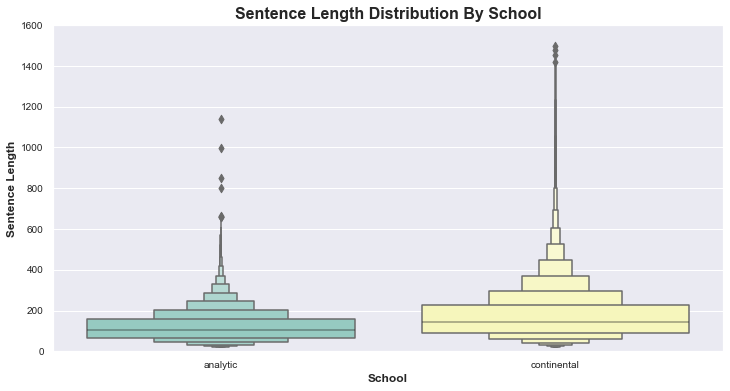

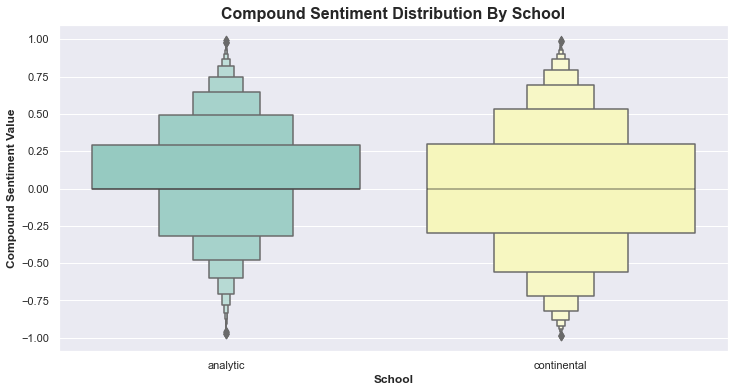

In [9]:
# plot sentence length split by school
plt.figure(figsize=(12,6))
sns.set(font_scale=1.5)
sns.boxenplot(x='school', y='sentence_length', data=df, palette="Set3")
plt.title('Sentence Length Distribution By School', fontsize=16, fontweight='bold')
plt.xlabel('School', fontsize=12, fontweight='bold')
plt.ylabel('Sentence Length', fontsize=12, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=10) # Decrease tick size
plt.ylim(0,1600) # Limit y-axis range

# plot compound sentiment split by school
plt.figure(figsize=(12,6))
sns.set(font_scale=1)
sns.boxenplot(x='school', y='compound_sent_score', data=df, palette="Set3")
plt.title('Compound Sentiment Distribution By School', fontsize=16, fontweight='bold')
plt.xlabel('School', fontsize=12, fontweight='bold')
plt.ylabel('Compound Sentiment Value', fontsize=12, fontweight='bold')

Initial analysis using the two plots above confirms both of my expectations. Analytic philosophy sentences are generally longer while continental philosophy sentences are generally more negative, although one could not say, from this plot that they are negative, since the distribution is almost perfectly symmetric acrosss neutral mark of zero compound score. I expected analytic philosophy to have a more objective language--this exposes an inconsistency that should be explored further. 

-----------------------------------------------------------

#### 3.3 Sentence Length Frequency Distribution Between the Two Schools 

Analyzing the distribution of sentence lengths can be useful for identifying differences in the writing styles of philosophers in the two traditions in otder to identify patterns or trends in the way that ideas are presented and communicated. Using the hist function from matplotlib, the code below generates a figure with two subplots, each containing a histogram that displays the distribution of sentence lengths in the data. 

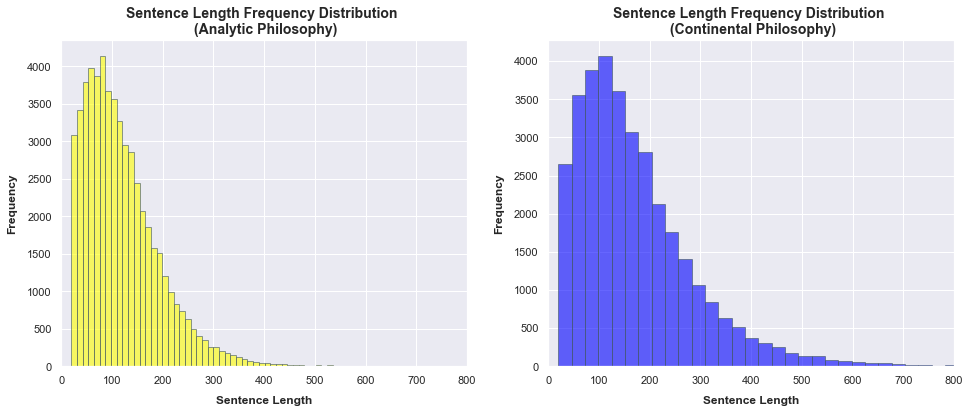

In [ ]:
# Create a figure with 2 subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Extract the sentence lengths from the data
sentence_lengths_analytic = df_analytic['sentence_length']

# Plot the first histogram in the first subplot
ax[0].hist(sentence_lengths_analytic, 100, color='#FFFF00', alpha=0.6, edgecolor='#455A64')

# Add a title and axis labels to the first subplot
ax[0].set_title('Sentence Length Frequency Distribution \n (Analytic Philosophy)', fontsize=14, fontweight='bold')
ax[0].set_xlabel('Sentence Length', fontsize=12, labelpad=10, fontweight='bold')
ax[0].set_ylabel('Frequency', fontsize=12, labelpad=10, fontweight='bold')
ax[0].set_xlim(0, 800)


# Extract the sentence lengths from the data
sentence_lengths_continental = df_continental['sentence_length']

# Plot the second histogram in the second subplot
ax[1].hist(sentence_lengths_continental, 100, color='#0000FF', alpha=0.6, edgecolor='#455A64')

# Add a title and axis labels to the second subplot
ax[1].set_title('Sentence Length Frequency Distribution \n (Continental Philosophy)', fontsize=14, fontweight='bold')
ax[1].set_xlabel('Sentence Length', fontsize=12, labelpad=10, fontweight='bold')
ax[1].set_ylabel('Frequency', fontsize=12, labelpad=10, fontweight='bold')
ax[1].set_xlim(0, 800)

# Show the plot
plt.show()




-----------------------------------------------------------
#### 3.3 Compound Sentiment Score Across Time Between the Two Schools 

Similarly to analysis in 2.3, it is crucial to leverage the time variable to investigate for potential trends in sentiment score across the years, and figure out if the trends might have substaintially skewed the differences noticed above. Following the high-level concusions from investigation of the whole dataset in 2.3, I would expect both of the schools of thought to have decreasing sentiment scores as they approach modernity, but the limited time range of data in the dataset might make this analysis very limited. 


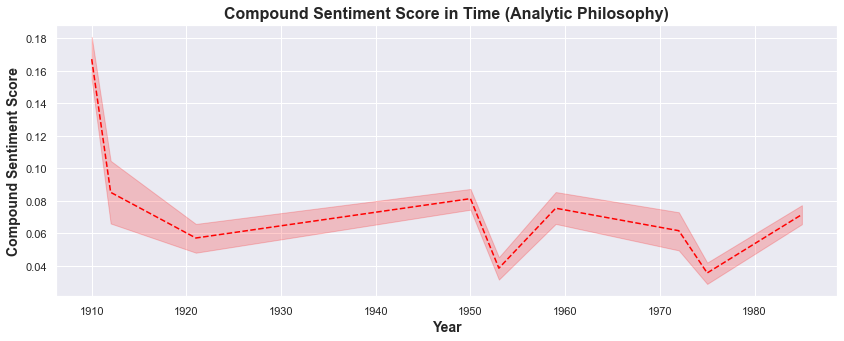

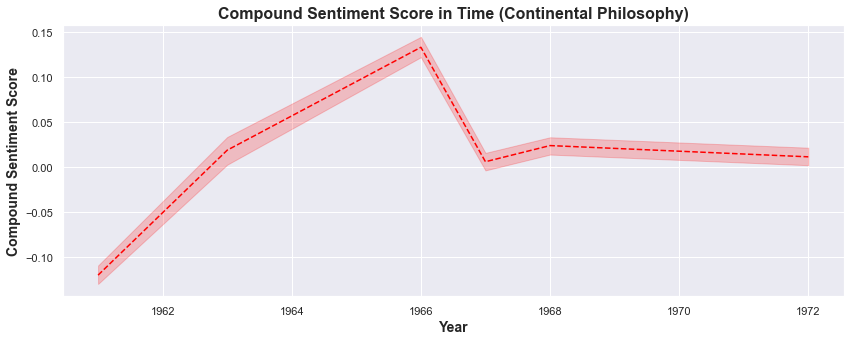

In [501]:
plt.figure(figsize=(14,5))
sns.lineplot(data=df_analytic, x='year', y='compound_sent_score', linestyle='--', color='red')
plt.grid(True)
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Compound Sentiment Score', fontsize=14, fontweight='bold')
plt.title("Compound Sentiment Score in Time (Analytic Philosophy)", fontsize=16, fontweight='bold')
plt.show()

plt.figure(figsize=(14,5))
sns.lineplot(data=df_continental, x='year', y='compound_sent_score', linestyle='--', color='red')
plt.grid(True)
plt.xlabel('Year', fontsize=14, fontweight='bold')
plt.ylabel('Compound Sentiment Score', fontsize=14, fontweight='bold')
plt.title("Compound Sentiment Score in Time (Continental Philosophy)", fontsize=16, fontweight='bold')
plt.show()

The first thing that must be observed is the limited value range of the time variable here. Analytic philosophy dataset has only 9 discrete year values, while the continental philosophy dataset has only 6 discrete time datapoints. This makes analysis of any longitudinal trends extremely limited in quality. Nevertheless, rudimentary observation show an inverse trend, where analytic philosophy sentiment scores initially fell, to then remain constant, while continental sentiment scores originated at negative values to then grow to positive sentiment, and plateau converging to neutral scores. This should be investigated further across more discrete time variables, and a longer range for any observations to be truly conclusive.

-----------------------------------------------------------
#### 3.4 Wordcloud Analysis of the Two Schools of Thought


Analyzing the content and language used in texts from the two philosophical traditions can be especially efficient by generating wordcloud. If the word cloud for texts from the analytic tradition is dominated by words related to abstract concepts and logical reasoning, this could suggest that philosophers in this tradition are expected to present their ideas in a clear and logical manner, and to focus on formal, abstract concepts. On the other hand, if the word cloud for texts from the continental tradition is dominated by words related to culture and human experience, this could suggest that philosophers in this tradition are expected to pay more attention to the subjective and cultural aspects of human experience, and to consider the social and historical context of their ideas.

Using the WordCloud function from the wordcloud package, the code below generates word clouds from sentence_str variables of each of the two schools of thought. 

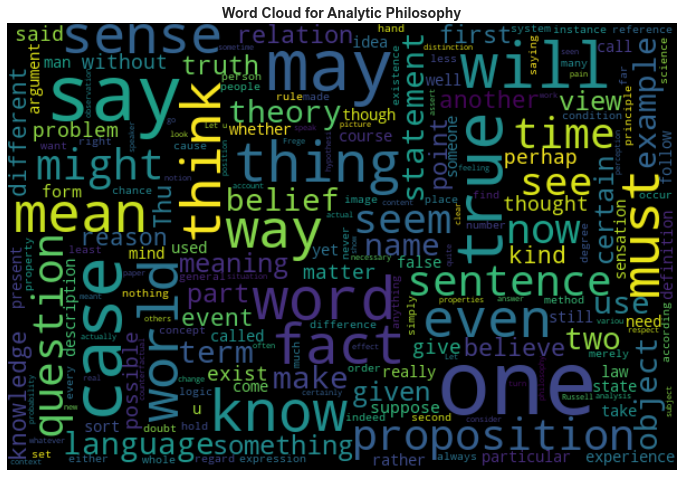

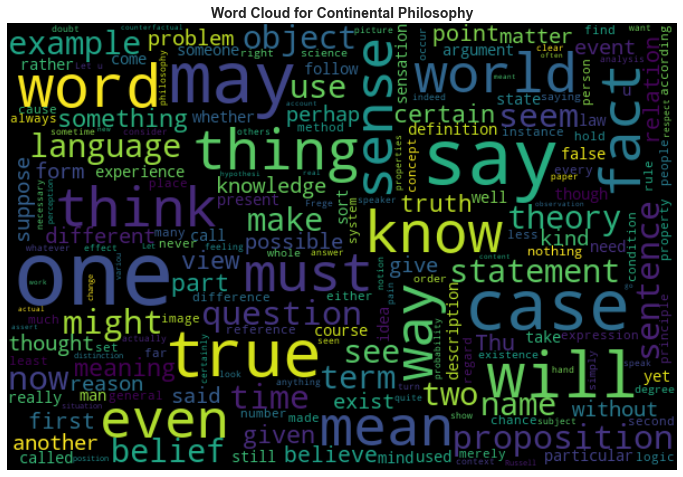

In [31]:
# Wordcloud for Analytical
# create an empty string to store all the sentences
all_sentences = ' '.join(df_analytic['sentence_str'])

# create a wordcloud object
wordcloud = WordCloud(max_font_size=80, width=600, height=400).generate(all_sentences)

# plot the wordcloud
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Analytic Philosophy', fontsize=14, fontweight='bold')
plt.show()


# Wordcloud for Continental
# create an empty string to store all the sentences
all_sentences = ' '.join(df_analytic['sentence_str'])

# create a wordcloud object
wordcloud = WordCloud(max_font_size=80, width=600, height=400).generate(all_sentences)

# plot the wordcloud
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Word Cloud for Continental Philosophy', fontsize=14, fontweight='bold')
plt.show()

Indeed, the two wordcloud display a lot of commonalities like word, one, may, true and other operational words that are charactersitic to the writing style of the field at large, as well as the shared worldtime of the schools. Nevertheless, there are some key differences such as the relative importance of words like object, language or relation for the analytic trend, which--true to expectations--relate to inanimate theoretical objects that the field usually considers. Similarly, continental tradition shows higher frequency of words like matter, statement, suppose and such, which display their strong relational attachment to societal objects as well as hypothetical modes of thinking.

------------------------------------------------------------------------------------------------------------------------------------
#### 3.5 In-Depth Analysis: Emotion classification

The contrast which I find most interesting to explore is the emotional character of the language. Having noticed significant differences in the sentiment scores of the two schools, I want to dvelve deeper into the emotional composition of the schools of thought by analysing the lemmatized strings in the dataset across ten main emotion labels that are as follows: positive, negative, anticipation, anger, surprise, trust, sadness, joy, fear, and disgust. I analyse the lemmatized words aiming to identify the primary and secondary emotions dominating the words in each string. 

##### 3.5.1 Applying NRCLex Emotion classification Models

The NRCLex function from the nrclex package enabled me to identify the primary and secondary emotions present in each sentence of the dataframe. The code iterates through the rows of the dataframe and uses the "lemmatized_str" column to create an NRCLex object for each sentence. The top_emotions attribute of the NRCLex object is then used to get the top emotion for each sentence. The top emotion is extracted from the returned tuple and added to the list of primary emotions, while the second emotion in the tuple is added to the list of secondary emotions.

In [32]:
# Using NRCLex to get main emotions of each sentence in the df
# Create an empty list to store the emotion labels
emotion_labels = []

# Iterate through the rows of the dataframe
for i, row in df.iterrows():
  # Get the lemmatized text
  lemmatized_text = row['lemmatized_str']

  # Create an NRCLex object for the text
  emotion = NRCLex(lemmatized_text)

  # Get the top emotion for the text
  top_emotion = emotion.top_emotions

  # Append the top emotion label to the list
  emotion_labels.append(top_emotion)

# Create an empty list to store the main emotions
primary_emotions = []
secondary_emotions = []


# Iterate through the emotion labels
for emotion in emotion_labels:
  # Extract the primary emotion from the emotion tuple
  main_emotion = emotion[0][0]

  # Append the secondary and primary emotion to the list
  primary_emotions.append(main_emotion)
  if len(emotion) > 1:
      secondary_emotion = emotion[1][0]
  else:
      secondary_emotion = main_emotion
  secondary_emotions.append(secondary_emotion)


df['primary_emotion'] = primary_emotions
df['secondary_emotion'] = secondary_emotions
df.head(10)



,title,author,school,sentence_str,year,sentence_length,sentence_lowered,tokenized_txt,lemmatized_str,compound_sent_score,primary_emotion,secondary_emotion
0,The Analysis Of Mind,Russell,analytic,This book has grown out of an attempt to harmo...,1921,217,this book has grown out of an attempt to harmo...,"['this', 'book', 'has', 'grown', 'out', 'of', ...",this book have grow out of an attempt to harm...,0.6369,positive,positive
1,The Analysis Of Mind,Russell,analytic,"On the one hand, many psychologists, especiall...",1921,186,"on the one hand, many psychologists, especiall...","['on', 'the', 'one', 'hand', 'many', 'psycholo...","on the one hand , many psychologist , especia...",0.6124,trust,trust
2,The Analysis Of Mind,Russell,analytic,They make psychology increasingly dependent on...,1921,167,they make psychology increasingly dependent on...,"['they', 'make', 'psychology', 'increasingly',...",-PRON- make psychology increasingly dependent...,0.2484,positive,positive
3,The Analysis Of Mind,Russell,analytic,"Meanwhile the physicists, especially Einstein ...",1921,142,"meanwhile the physicists, especially einstein ...","['meanwhile', 'the', 'physicists', 'especially...","meanwhile the physicist , especially Einstein...",0.0258,trust,trust
4,The Analysis Of Mind,Russell,analytic,"Their world consists of events, from which mat...",1921,87,"their world consists of events, from which mat...","['their', 'world', 'consists', 'of', 'events',...","-PRON- world consist of event , from which ma...",0.0258,positive,positive
5,The Analysis Of Mind,Russell,analytic,"Whoever reads, for example, Professor Eddingto...",1921,193,"whoever reads, for example, professor eddingto...","['whoever', 'reads', 'for', 'example', 'profes...","whoever read , for example , Professor Edding...",0.1280,positive,negative
6,The Analysis Of Mind,Russell,analytic,I think that what has permanent value in the o...,1921,158,i think that what has permanent value in the o...,"['think', 'that', 'what', 'has', 'permanent', ...",-PRON- think that what have permanent value i...,0.4404,positive,positive
7,The Analysis Of Mind,Russell,analytic,But this position cannot be called materialist...,1921,127,but this position cannot be called materialist...,"['but', 'this', 'position', 'cannot', 'be', 'c...",but this position can not be call materialist...,0.0387,positive,positive
8,The Analysis Of Mind,Russell,analytic,The view that seems to me to reconcile the mat...,1921,317,the view that seems to me to reconcile the mat...,"['the', 'view', 'that', 'seems', 'to', 'me', '...",the view that seem to -PRON- to reconcile the...,-0.1655,positive,positive
9,The Analysis Of Mind,Russell,analytic,I have endeavoured in this work to develop thi...,1921,128,i have endeavoured in this work to develop thi...,"['have', 'endeavoured', 'in', 'this', 'work', ...",-PRON- have endeavour in this work to develop...,0.0000,positive,anticipation


##### 3.5.1 Preprocessing New Data

In order to illustrate the differences between the two measures, I create to frequency dataframes for the primary and secondary emotion frequency of each school of thought.

In [33]:

df_analytic = df.loc[df['school'].isin(['analytic'])]
df_continental = df.loc[df['school'].isin(['continental'])]

emot_freq_analytical = dict(Counter(df_analytic["primary_emotion"]))
emot_freq_continental = dict(Counter(df_continental["primary_emotion"]))

emot_freq_df = pd.DataFrame([emot_freq_analytical, emot_freq_continental])
selected_schools = ['analytic','continental']
emot_freq_df.insert(0, 'school', selected_schools)
emot_freq_df.insert(6, 'trust', emot_freq_df.pop('trust'))
emot_freq_df.insert(9, 'fear', emot_freq_df.pop('fear'))



sec_emot_freq_analytical = dict(Counter(df_analytic["secondary_emotion"]))
sec_emot_freq_continental = dict(Counter(df_continental["secondary_emotion"]))

sec_emot_freq_df = pd.DataFrame([sec_emot_freq_analytical, sec_emot_freq_continental])
sec_emot_freq_df.insert(0, 'school', selected_schools)
sec_emot_freq_df.insert(6, 'trust', sec_emot_freq_df.pop('trust'))
sec_emot_freq_df.insert(9, 'fear', sec_emot_freq_df.pop('fear'))



##### 3.5.2 Plotting Primary and Secondary Emotion Frequency Across the Two Schhols

This code generates two polar plots using the matplotlib library, which are used to compare the frequency of primary and secondary emotions in texts from the analytic and continental philosophical traditions. The first plot displays the frequency distribution of primary emotions, while the second plot displays the frequency distribution of secondary emotions. The code uses the dataframes "emot_freq_df" and "sec_emot_freq_df" to get the frequency values for each emotion in each tradition.


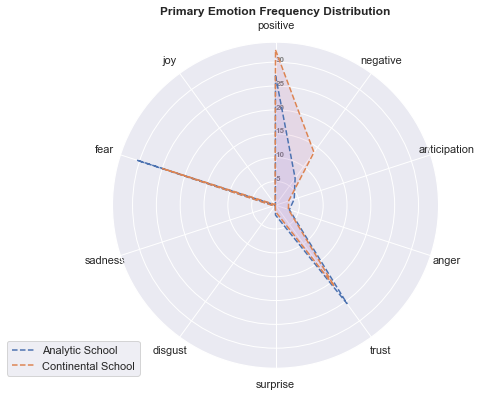

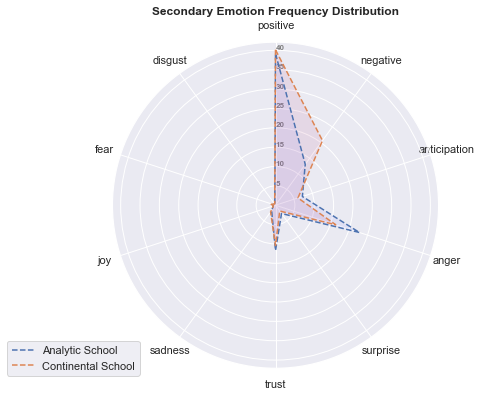

In [35]:
# ------- PART 1: Primary Emotions -------

# Set figure size
plt.figure(figsize=(26, 6))

# number of variable
categories=list(emot_freq_df)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)

# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)

# Add title
plt.title('Primary Emotion Frequency Distribution', fontsize=12, fontweight='bold')


# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks(color="grey", size=8, fontweight='bold')

 
# Plot each individual = each line of the data
# I don't make a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values = emot_freq_df.loc[0].drop('school').values.flatten().tolist()
total_count = sum(values)  # calculate total count
values = [val / total_count * 100 for val in values]  # convert counts to percentage
values += values[:1]
lines, = ax.plot(angles, values, linewidth=1.5, linestyle='dashed', label="Analytic School")

polys = ax.fill(angles, values, alpha=0.1)

# Set color for fill between lines and axes for group A
polys[0].set_facecolor(cm.cool(0.5))  # use 0.5 as the color value for the cool colormap
 
# Ind2
values = emot_freq_df.loc[1].drop('school').values.flatten().tolist()
total_count = sum(values)  # calculate total count
values = [val / total_count * 100 for val in values]  # convert counts to percentage
values += values[:1]
lines, = ax.plot(angles, values, linewidth=1.5, linestyle='dashed', label="Continental School")
polys = ax.fill(angles, values, alpha=0.1)

# Set color for fill between lines and axes for group B
polys[0].set_facecolor(cm.magma(0.5))  # use 0.5 as the color value for the cool colormap
 
# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# Show the graph
plt.show()


# ------- PART 2: Secondary Emotions: repeat -------

plt.figure(figsize=(26, 6))

categories=list(sec_emot_freq_df)[1:]
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
ax = plt.subplot(111, polar=True)

ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

plt.xticks(angles[:-1], categories)
plt.title('Secondary Emotion Frequency Distribution', fontsize=12, fontweight='bold')
ax.set_rlabel_position(0)
plt.yticks(color="grey", size=8, fontweight='bold')
 
values = sec_emot_freq_df.loc[0].drop('school').values.flatten().tolist()
total_count = sum(values)  # calculate total count

values = [val / total_count * 100 for val in values]  # convert counts to percentage
values += values[:1]
lines, = ax.plot(angles, values, linewidth=1.5, linestyle='dashed', label="Analytic School")

polys = ax.fill(angles, values, alpha=0.1)
polys[0].set_facecolor(cm.cool(0.5))  # use 0.5 as the color value for the cool colormap
values = sec_emot_freq_df.loc[1].drop('school').values.flatten().tolist()
total_count = sum(values)  # calculate total count
values = [val / total_count * 100 for val in values]  # convert counts to percentage
values += values[:1]
lines, = ax.plot(angles, values, linewidth=1.5, linestyle='dashed', label="Continental School")
polys = ax.fill(angles, values, alpha=0.1)
polys[0].set_facecolor(cm.magma(0.5))  # use 0.5 as the color value for the cool colormap
 
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()


Interstingly, when scaled down to ratio, the two schools of thought display almost identical emotion distributions for primary emotions as well as secondary emotions. The general trend is that the NRCLex model found most of the sentences to be primarily either positive, negative, trustful or fearful. This is interesting, because all of the above are opposites to each other according to the API of the model. This suggests that the method might not be the best way to analyse the sentences, because clearly, the true emotional charactersitc of most sentences characterised under those subgroups lays somewhere in the spectrum between the pairs: either between positive and negative or trustful and fearful. This shows that emotion classification of this dataset leaves a lot more to be done. 

-----------------------------------------------------------
-----------------------------------------------------------
### 4. Conclusion

The results of the analysis revealed a number of important insights into the nature of philosophical writing. Firstly, it became evident that there were significant discrepancies in the frequency of data among different philosophers and schools of thought, with certain authors, such as Plato and Aristotle, being particularly well-represented in the dataset. Additionally, the analysis revealed a historiographical gap in philosophical work between the fall of Rome in the 400s and the rise of rationalist philosophers in the 1600s.

In terms of the sentiment and sentence length analysis, the results were somewhat more nuanced. When examining the full dataset, no strong patterns were discerned in relation to the relationship between these two variables and the philosophers or schools of thought under consideration. However, when the analysis was narrowed to focus on two specific schools of thought, it became evident that there were noticeable differences in both the distribution of sentiments and the length of sentences. These findings suggest that there may be scope for further investigation of these variables in relation to philosophical writing, potentially through the use of more granular analysis techniques, such as those that examine the content of the sentences in terms of parts of speech and other linguistic features.

Overall, this exploratory data analysis has provided a valuable foundation for future research on the history of philosophy, highlighting the potential for data analysis techniques to shed light on the nature of philosophical writing and the ways in which it has evolved over time.

-----------------------------------------------------------
-----------------------------------------------------------
### 5. Limitation and Further Work

Despite the insights provided by this exploratory data analysis, it is important to consider the limitations of the study. One key limitation is the fact that the dataset analyzed in this study is not comprehensive, comprising only a selection of philosophers and works rather than a representative sample of the entire history of philosophy. As such, the results of the analysis should be interpreted with caution, as they may not be fully representative of the field as a whole.

In addition, the analysis was limited by the tools and techniques used. For example, the SentimentIntensityAnalyzer, while a widely-used tool for generating sentiment scores, has been criticized for its reliance on a pre-determined list of words with associated sentiment values, which may not accurately reflect the sentiment of certain text. To address this issue, future research could utilize machine learning techniques, such as supervised learning approaches that involve training a model on a labeled dataset of texts with known sentiments, or unsupervised learning techniques such as topic modeling or clustering algorithms that can identify patterns in the data without requiring explicit labels. Other machine learning models that could be effective for sentiment analysis in this context include convolutional neural networks (CNNs) and long short-term memory (LSTM) networks.

Overall, it is clear that there is still much work to be done in order to fully understand the nature of philosophical writing and the ways in which it has evolved over time. In order to address the issue of representativeness, future research could utilize larger, more comprehensive datasets that include a wider range of philosophers and works. Additionally, the inclusion of a wider range of analysis techniques, such as machine learning approaches to sentiment analysis and the examination of other linguistic features, could provide a more nuanced and comprehensive understanding of the field.